In [1]:
size = 64
batchSize = 70
train_path = "images/train/"
test_path = "images/test/"
epoch_num = 1

In [2]:
import kornia as kornia
import numpy as np
import plotly.express as px
import torch
from kornia.color import lab_to_rgb, rgb_to_linear_rgb, rgb_to_xyz, xyz_to_rgb, linear_rgb_to_rgb
from skimage import color
import torchvision.transforms as T
import torchvision.datasets
from skimage.io import imshow
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# For plotting
import numpy as np
import matplotlib.pyplot as plt
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time
from torch.utils.data import DataLoader

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def rgb_to_lab(image: torch.Tensor) -> torch.Tensor:
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    # Convert from sRGB to Linear RGB
    lin_rgb = rgb_to_linear_rgb(image)

    xyz_im: torch.Tensor = rgb_to_xyz(lin_rgb)

    # normalize for D65 white point
    xyz_ref_white = torch.tensor([0.95047, 1.0, 1.08883], device=xyz_im.device, dtype=xyz_im.dtype)[..., :, None, None]
    xyz_normalized = torch.div(xyz_im, xyz_ref_white)

    threshold = 0.008856
    power = torch.pow(xyz_normalized.clamp(min=threshold), 1 / 3.0)
    scale = 7.787 * xyz_normalized + 4.0 / 29.0
    xyz_int = torch.where(xyz_normalized > threshold, power, scale)

    x: torch.Tensor = xyz_int[..., 0, :, :]
    y: torch.Tensor = xyz_int[..., 1, :, :]
    z: torch.Tensor = xyz_int[..., 2, :, :]

    L: torch.Tensor = (116.0 * y) - 16.0
    a: torch.Tensor = 500.0 * (x - y)
    _b: torch.Tensor = 200.0 * (y - z)

    out: torch.Tensor = torch.stack([L, a, _b], dim=-3)

    return out

In [4]:
def lab_to_rgb(L: torch.Tensor, a: torch.Tensor, _b: torch.Tensor, clip: bool = True) -> torch.Tensor:
    # if not isinstance(image, torch.Tensor):
    #     raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")
    #
    # if len(image.shape) < 3 or image.shape[-3] != 3:
    #     raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    # L: torch.Tensor = image[..., 0, :, :]
    # a: torch.Tensor = image[..., 1, :, :]
    # _b: torch.Tensor = image[..., 2, :, :]

    fy = (L + 16.0) / 116.0
    fx = (a / 500.0) + fy
    fz = fy - (_b / 200.0)

    # if color data out of range: Z < 0
    fz = fz.clamp(min=0.0)

    fxyz = torch.stack([fx, fy, fz], dim=-3)

    # Convert from Lab to XYZ
    power = torch.pow(fxyz, 3.0)
    scale = (fxyz - 4.0 / 29.0) / 7.787
    xyz = torch.where(fxyz > 0.2068966, power, scale)

    # For D65 white point
    xyz_ref_white = torch.tensor([0.95047, 1.0, 1.08883], device=xyz.device, dtype=xyz.dtype)[..., :, None, None]
    xyz_im = xyz * xyz_ref_white

    rgbs_im: torch.Tensor = xyz_to_rgb(xyz_im)

    # https://github.com/richzhang/colorization-pytorch/blob/66a1cb2e5258f7c8f374f582acc8b1ef99c13c27/util/util.py#L107
    #     rgbs_im = torch.where(rgbs_im < 0, torch.zeros_like(rgbs_im), rgbs_im)

    # Convert from RGB Linear to sRGB
    rgb_im = linear_rgb_to_rgb(rgbs_im)

    # Clip to 0,1 https://www.w3.org/Graphics/Color/srgb
    if clip:
        rgb_im = torch.clamp(rgb_im, min=0.0, max=1.0)

    return rgb_im

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

In [7]:
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True)

In [8]:
test_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=False)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Linear(size, size)
        self.layer2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )          

    def forward(self, x):
        x = self.layer1(x)
        out = self.layer2(x)
        return out

In [10]:
model = CNN().to(device)

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

In [12]:
loss_func = torch.nn.MSELoss()

In [13]:
losses = []
predictions = []
tempPred2 = []
batch_acc_list = []
LAB = []
LABForAllEpochs = []
for epoch in range(epoch_num):
    tempPred = []
    LAB1 = []
    Counter2 = 0
    for idx, (data, target) in enumerate(train_loader):
        Counter = 0
        Counter2 = Counter2 + 1
        for i in data:
            Counter = Counter + 1
            Lab = rgb_to_lab(i / (size-1))
            LAB1.append(Lab)
            x = Lab[0]
            x2 = np.array(x)
            L = torch.tensor(np.array([x2]))
            AB = Lab[1:3]
            # forward
            scores = model(L)
            tempPred.append(scores)
            loss = loss_func(scores, AB)
            losses.append(loss.item())
            # backward
            optimizer.zero_grad()
            loss.backward()
            # gradient descent step
            optimizer.step()
            if Counter%20 == 0:
                print(f'Epoch: {epoch} \t data in batch {Counter2}: {Counter}')
        LAB.append(LAB1)
        LAB1 = []
        tempPred2.append(tempPred)
        print("---------------------------")
        batch_acc = sum(losses)/len(losses)
        batch_acc_list.append(batch_acc)
        epoch_acc = sum(batch_acc_list)/len(batch_acc_list)
        losses = []
    predictions.append(tempPred2)
    tempPred2 = []
    LABForAllEpochs.append(LAB)
    LAB = []

Epoch: 0 	 data in batch 1: 20
Epoch: 0 	 data in batch 1: 40
Epoch: 0 	 data in batch 1: 60
---------------------------
Epoch: 0 	 data in batch 2: 20
Epoch: 0 	 data in batch 2: 40
Epoch: 0 	 data in batch 2: 60
---------------------------
Epoch: 0 	 data in batch 3: 20
Epoch: 0 	 data in batch 3: 40
Epoch: 0 	 data in batch 3: 60
---------------------------
Epoch: 0 	 data in batch 4: 20
Epoch: 0 	 data in batch 4: 40
Epoch: 0 	 data in batch 4: 60
---------------------------
Epoch: 0 	 data in batch 5: 20
Epoch: 0 	 data in batch 5: 40
Epoch: 0 	 data in batch 5: 60
---------------------------
Epoch: 0 	 data in batch 6: 20
Epoch: 0 	 data in batch 6: 40
Epoch: 0 	 data in batch 6: 60
---------------------------
Epoch: 0 	 data in batch 7: 20
Epoch: 0 	 data in batch 7: 40
Epoch: 0 	 data in batch 7: 60
---------------------------
Epoch: 0 	 data in batch 8: 20
Epoch: 0 	 data in batch 8: 40
Epoch: 0 	 data in batch 8: 60
---------------------------
Epoch: 0 	 data in batch 9: 20
E

In [14]:
print(len(LABForAllEpochs))
print(len(LABForAllEpochs[0]))
print(len(LABForAllEpochs[0][14]))

1
15
20


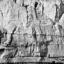

In [15]:
firstAB = predictions[0][0][20]
LAB2 = LABForAllEpochs[0][0][20]
transform = T.ToPILImage()
img = transform(LAB2[0])
img

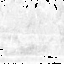

In [16]:
transform = T.ToPILImage()
img = transform(LAB2[1])
img

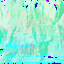

In [17]:
transform = T.ToPILImage()
img = transform(LAB2[0:3])
img

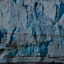

In [18]:
output = lab_to_rgb(LAB2[0]*(size-1), LAB2[1]*(size-1), LAB2[2]*(size-1))
img = transform(output)
img

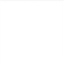

In [19]:
transform = T.ToPILImage()
img = transform(firstAB[1])
img

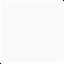

In [20]:
transform = T.ToPILImage()
img = transform(firstAB[0])
img

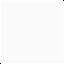

In [22]:
transform = T.ToPILImage()
img = transform(firstAB)
img

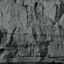

In [21]:
output = lab_to_rgb(LAB2[0]*(size-1), firstAB[0]*(size-1), firstAB[1]*(size-1))
img = transform(output)
img